In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns

In [11]:
df = pd.read_csv('data/sensor55__20250930_20251031.csv').drop(columns=['sensorId'])

df.head()

,timestamp,co2,humidity,light,motion,temperature
0,2025-09-30T22:00:12Z,394.0,46.0,3.0,0.0,22.2
1,2025-09-30T22:01:12Z,405.0,46.0,3.0,0.0,22.2
2,2025-09-30T22:02:12Z,412.0,46.0,3.0,0.0,22.2
3,2025-09-30T22:03:12Z,418.0,46.0,3.0,0.0,22.2
4,2025-09-30T22:04:12Z,427.0,46.0,3.0,0.0,22.2


In [12]:
df.describe()

,co2,humidity,light,motion,temperature
count,44573.000000,44573.000000,44573.000000,44573.000000,44573.000000
mean,699.820788,43.911381,35.250062,0.200637,21.024055
std,504.891304,6.239995,319.318320,0.785233,0.862005
min,357.000000,29.000000,3.000000,0.000000,18.900000
25%,408.000000,40.000000,3.000000,0.000000,20.400000
50%,470.000000,43.000000,3.000000,0.000000,21.100000
75%,732.000000,48.000000,20.000000,0.000000,21.600000
max,3253.000000,65.000000,12291.000000,8.000000,23.600000


In [13]:
df.dtypes

timestamp       object
co2            float64
humidity       float64
light          float64
motion         float64
temperature    float64
dtype: object

In [14]:
df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)

df = df.set_index('timestamp')

df.dtypes

co2            float64
humidity       float64
light          float64
motion         float64
temperature    float64
dtype: object

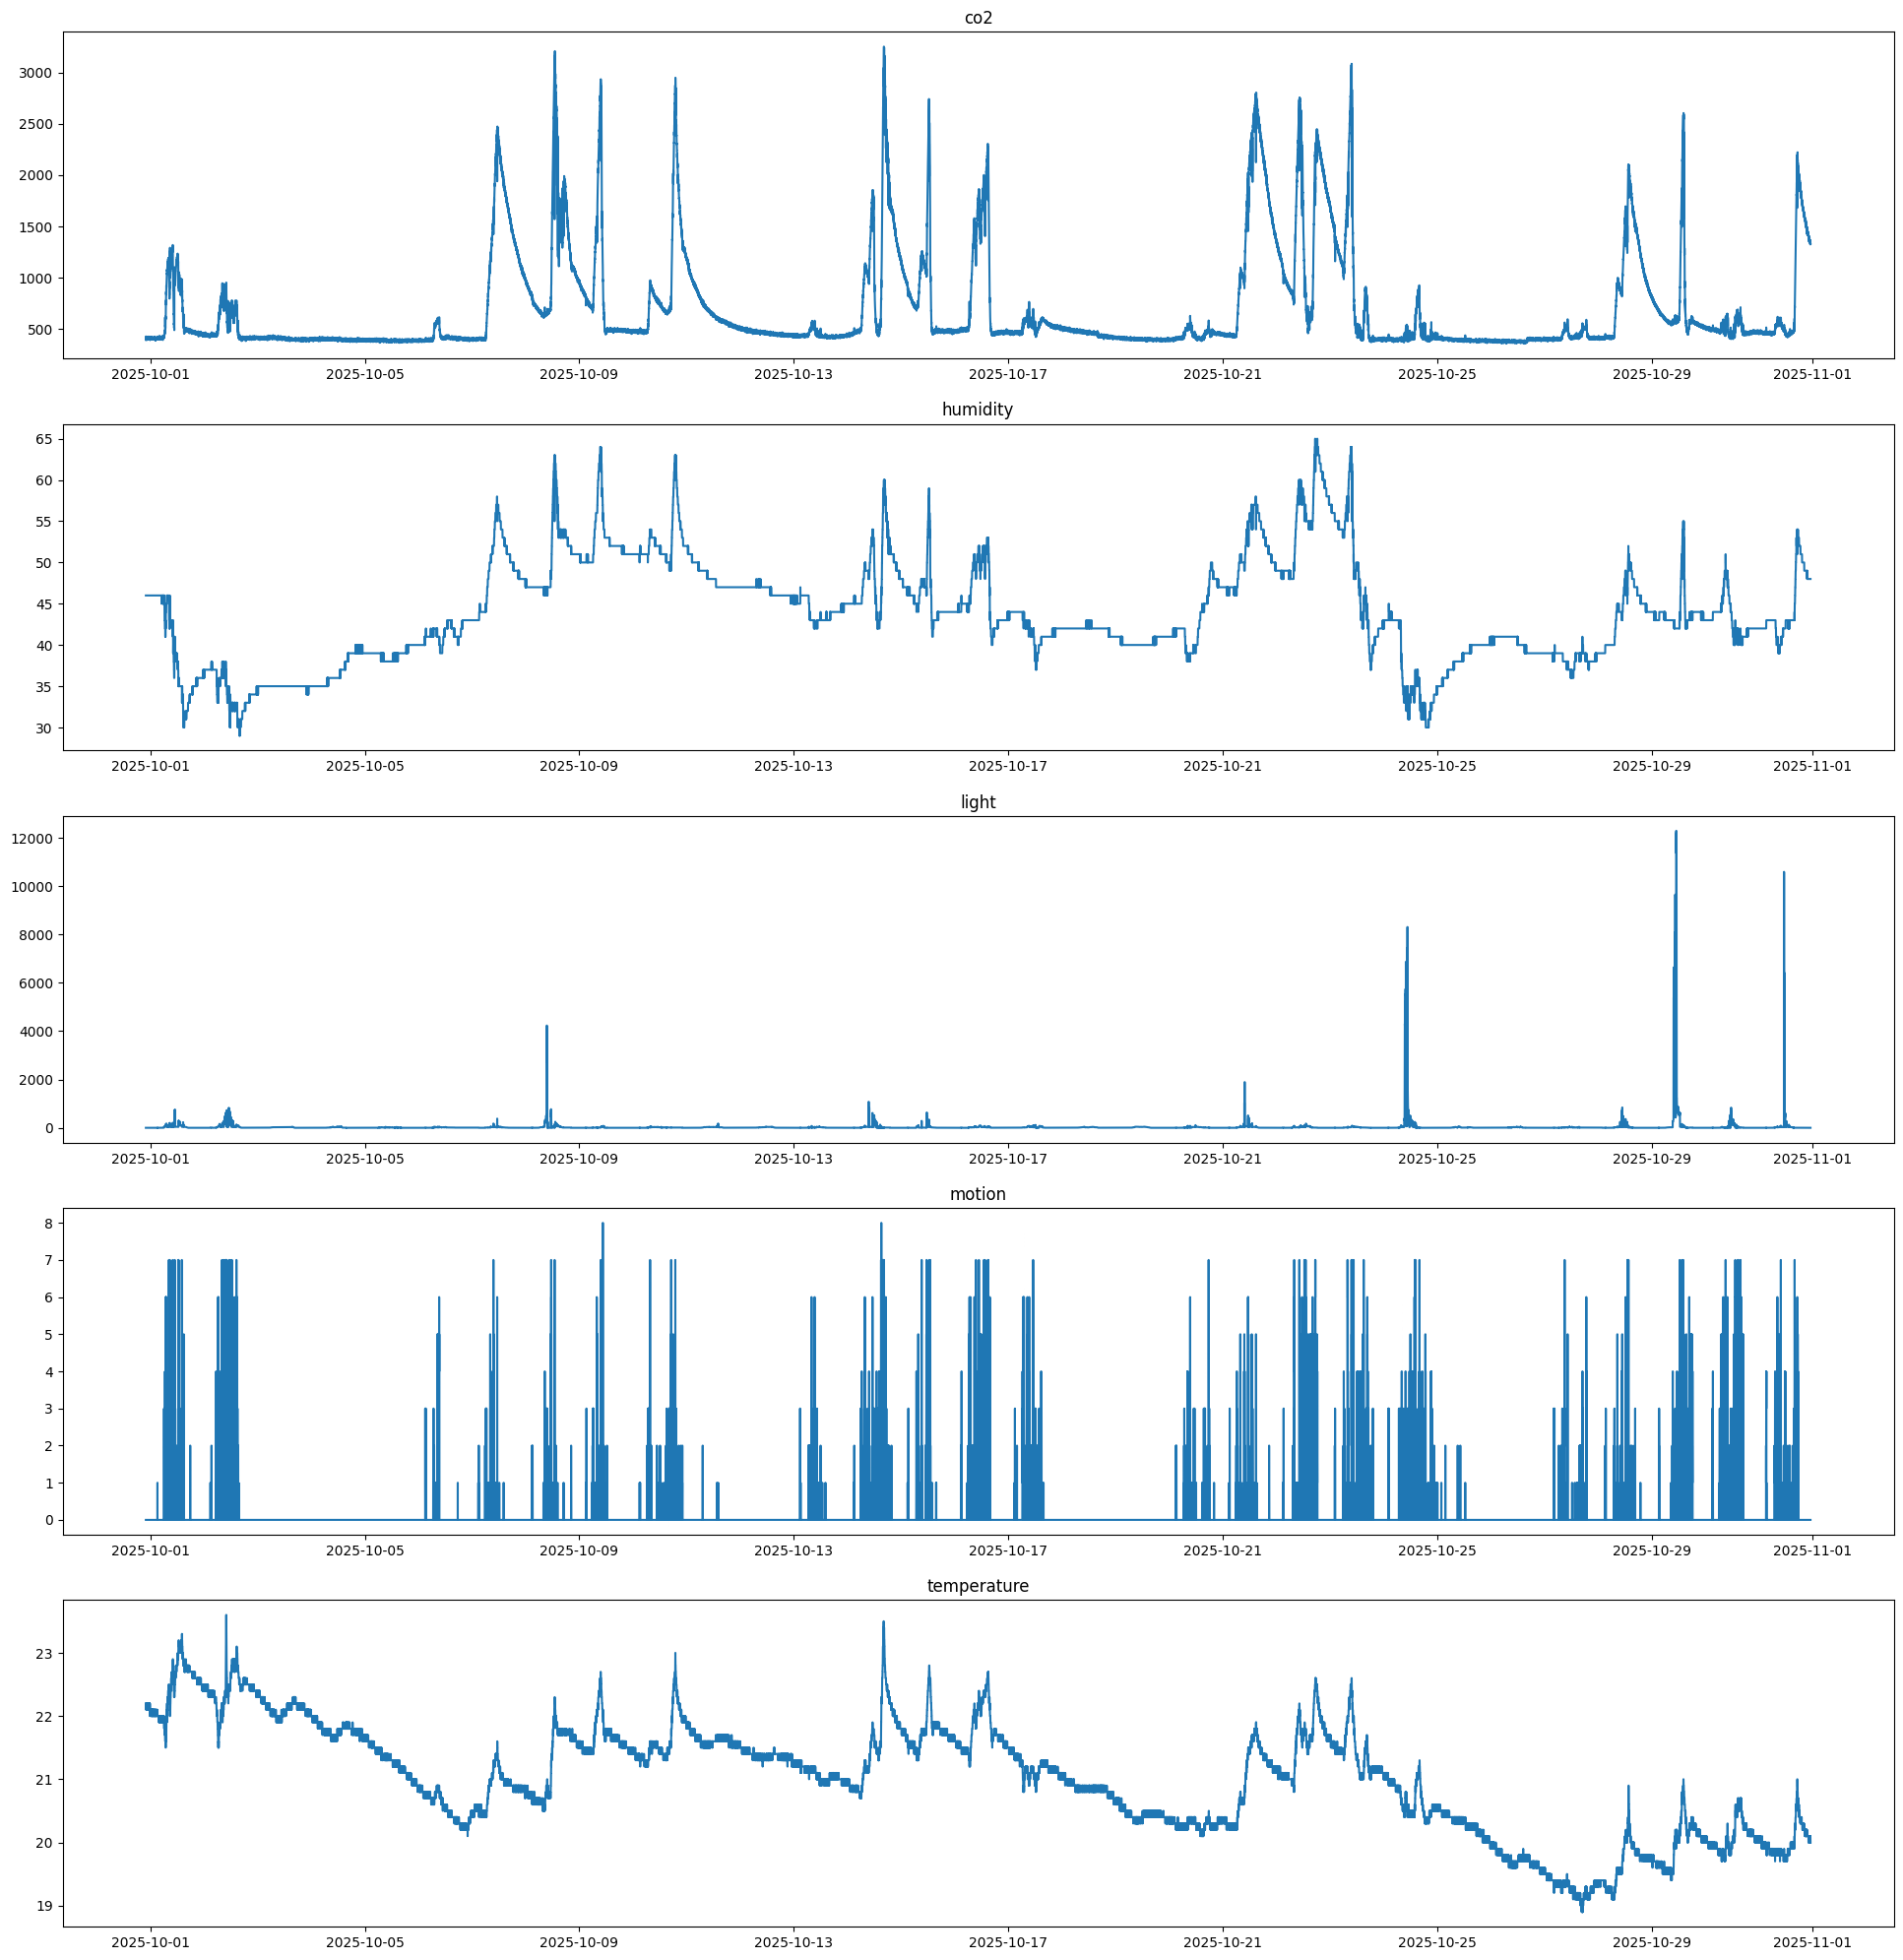

In [15]:
from matplotlib import use


df_year = df.loc['2025-10-01':'2025-11-01']

fig, ax = plt.subplots(5, 1, figsize=(24, 25))

for i, key in enumerate(df.keys().to_list()):
    ax[i].plot(df.index, df[key])
    ax[i].set_title(key)

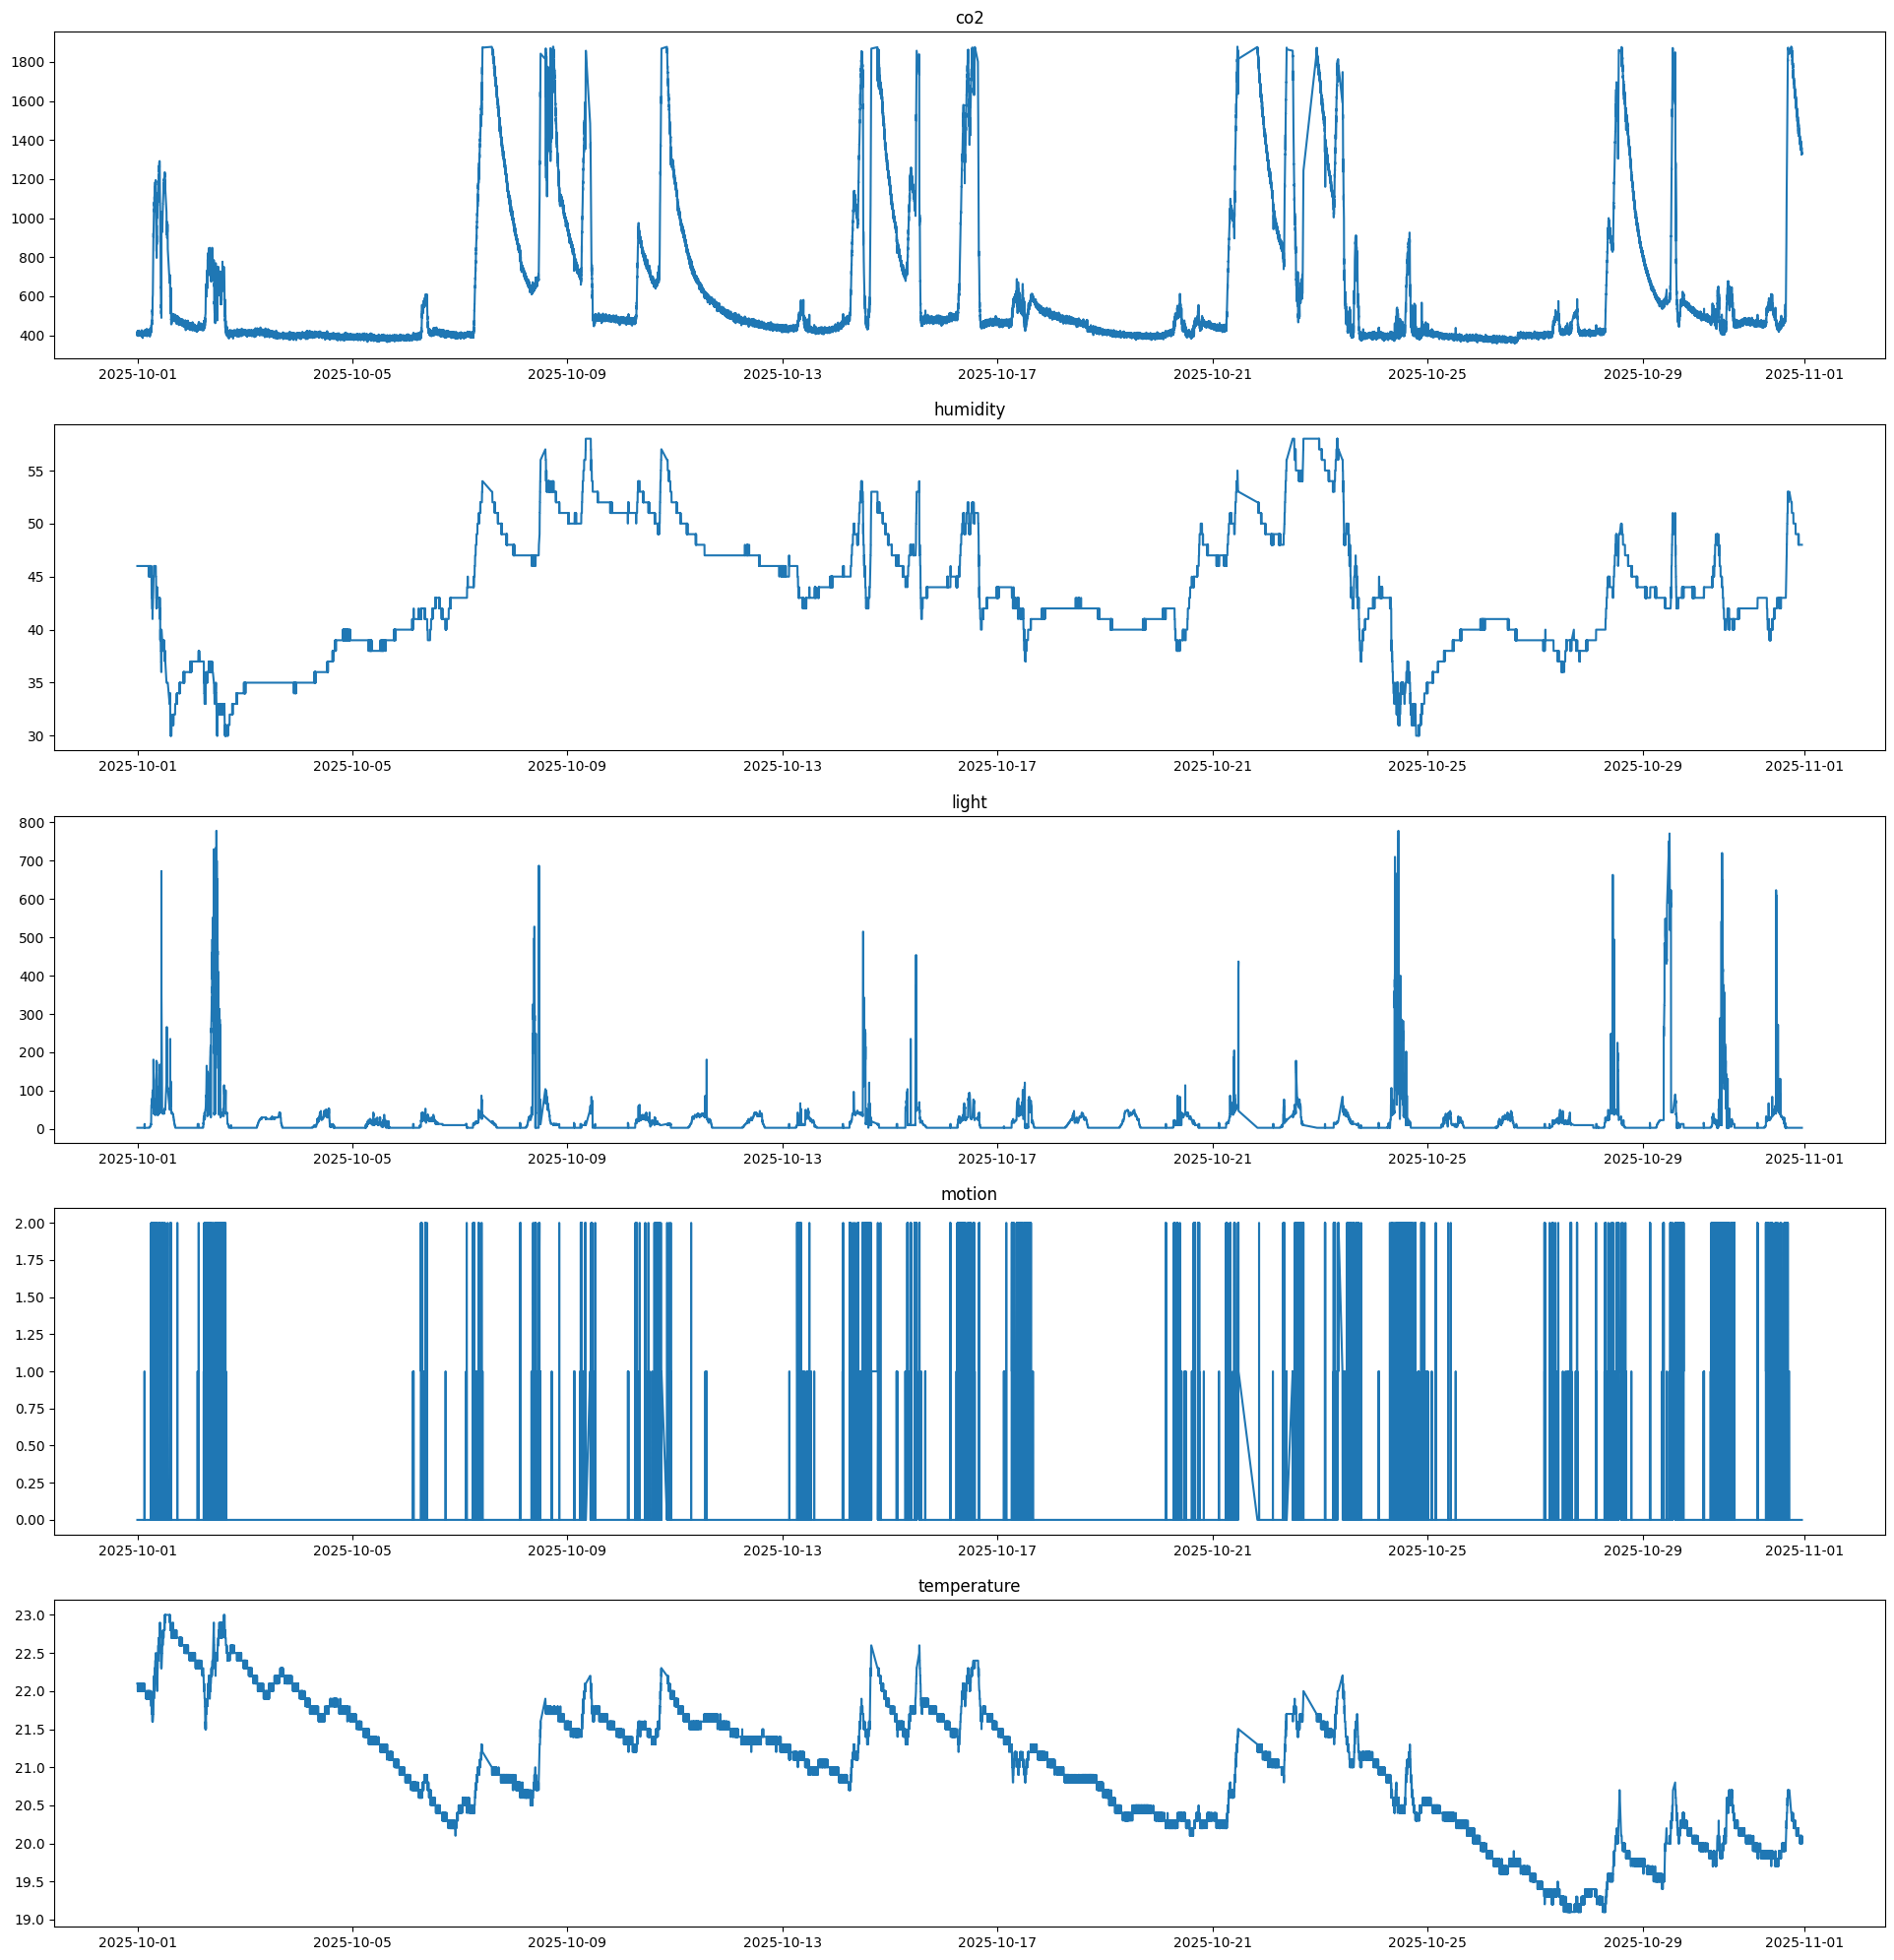

In [16]:
# Remove outliers using Z-score
# Remove all rows with std > 3 on numeric columns
numeric_cols = df_year.select_dtypes(include=[np.number]).columns
z_scores = (df_year[numeric_cols] - df_year[numeric_cols].mean()) / df_year[numeric_cols].std()
df_year = df_year[(np.abs(z_scores) < 2.33).all(axis=1)] # 2.3 equals approx 99% confidence interval

fig, ax = plt.subplots(5, 1, figsize=(24, 25))

for i, key in enumerate(df_year.keys().to_list()):
        ax[i].plot(df_year.index, df_year[key])
        ax[i].set_title(key)

<Axes: >

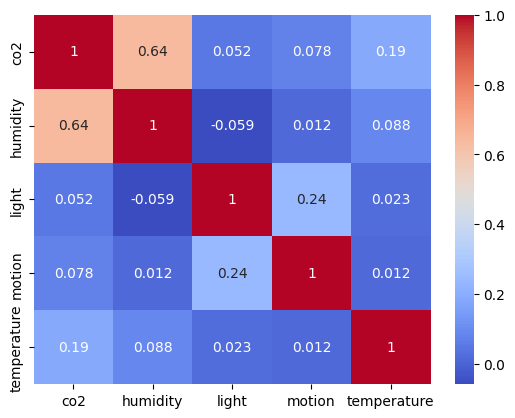

In [17]:
sns.heatmap(df_year.corr(), annot=True, cmap='coolwarm')


array([[<Axes: title={'center': 'co2'}>,
        <Axes: title={'center': 'humidity'}>],
       [<Axes: title={'center': 'light'}>,
        <Axes: title={'center': 'motion'}>],
       [<Axes: title={'center': 'temperature'}>, <Axes: >]], dtype=object)

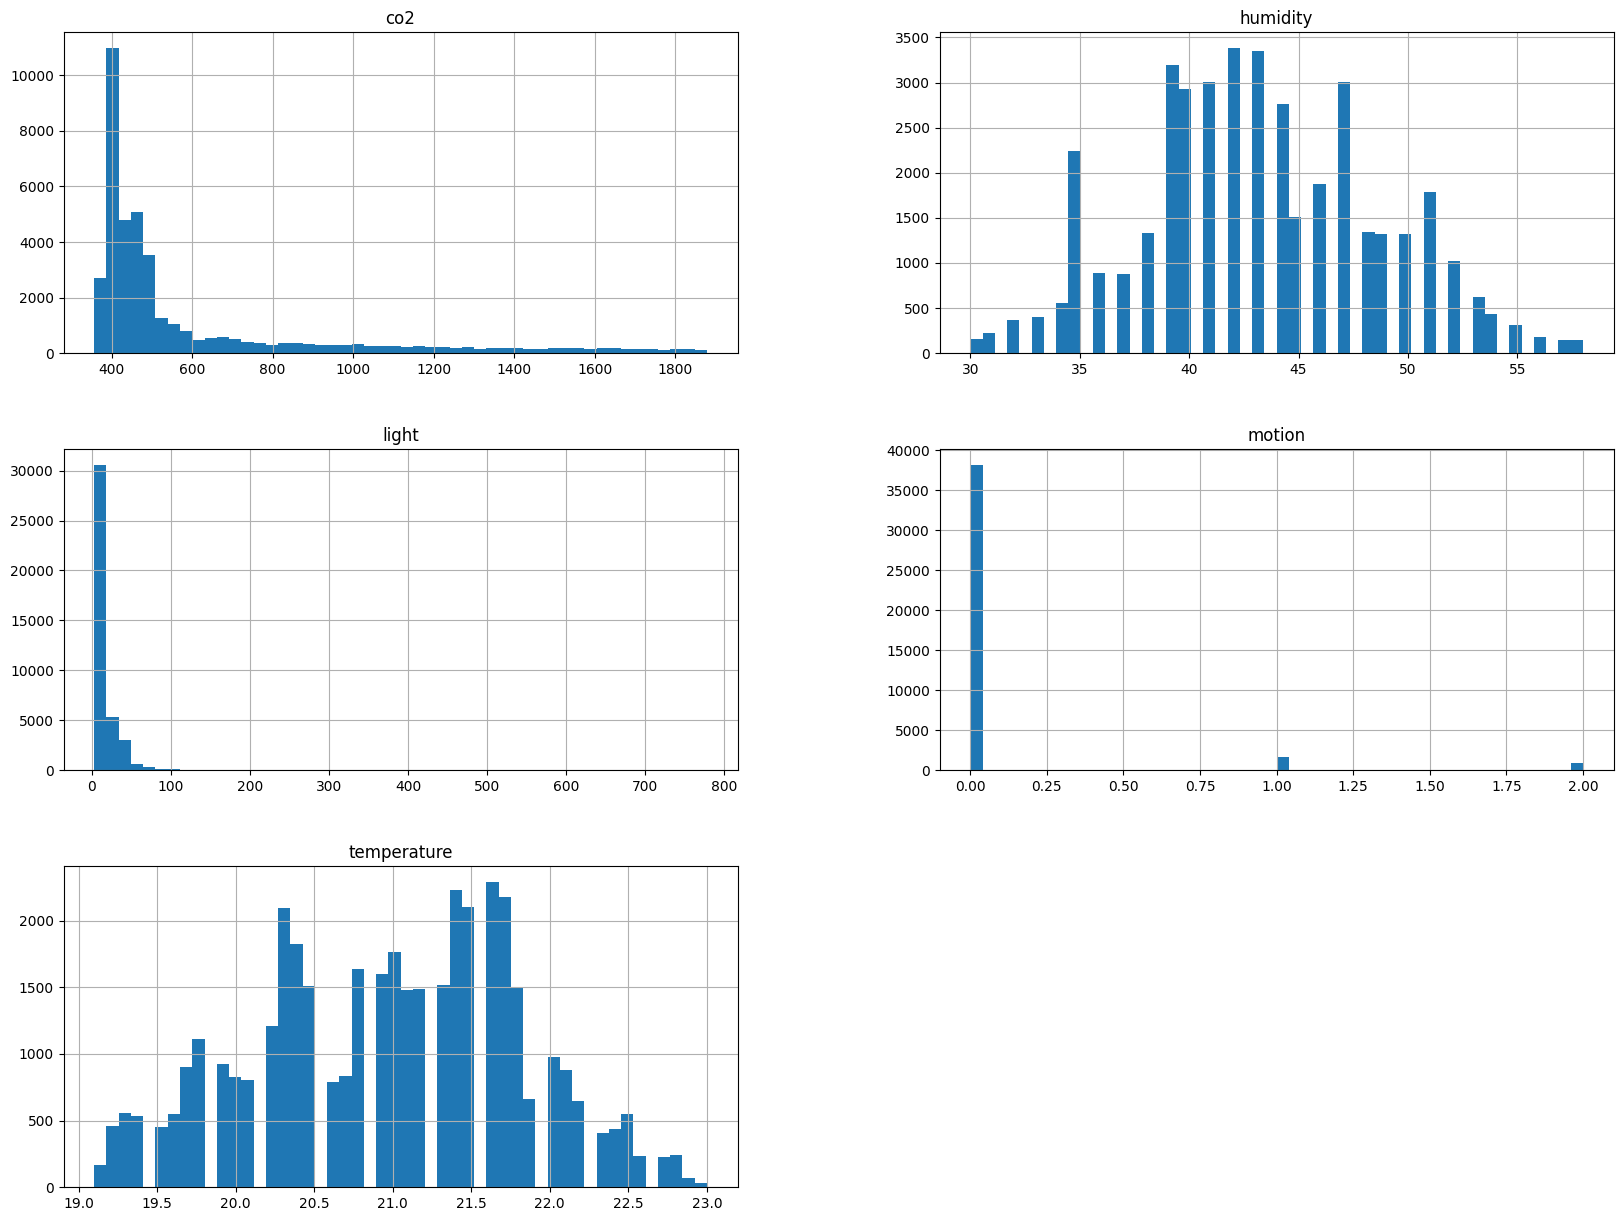

In [18]:
df_year.hist(bins=50, figsize=(20, 15))

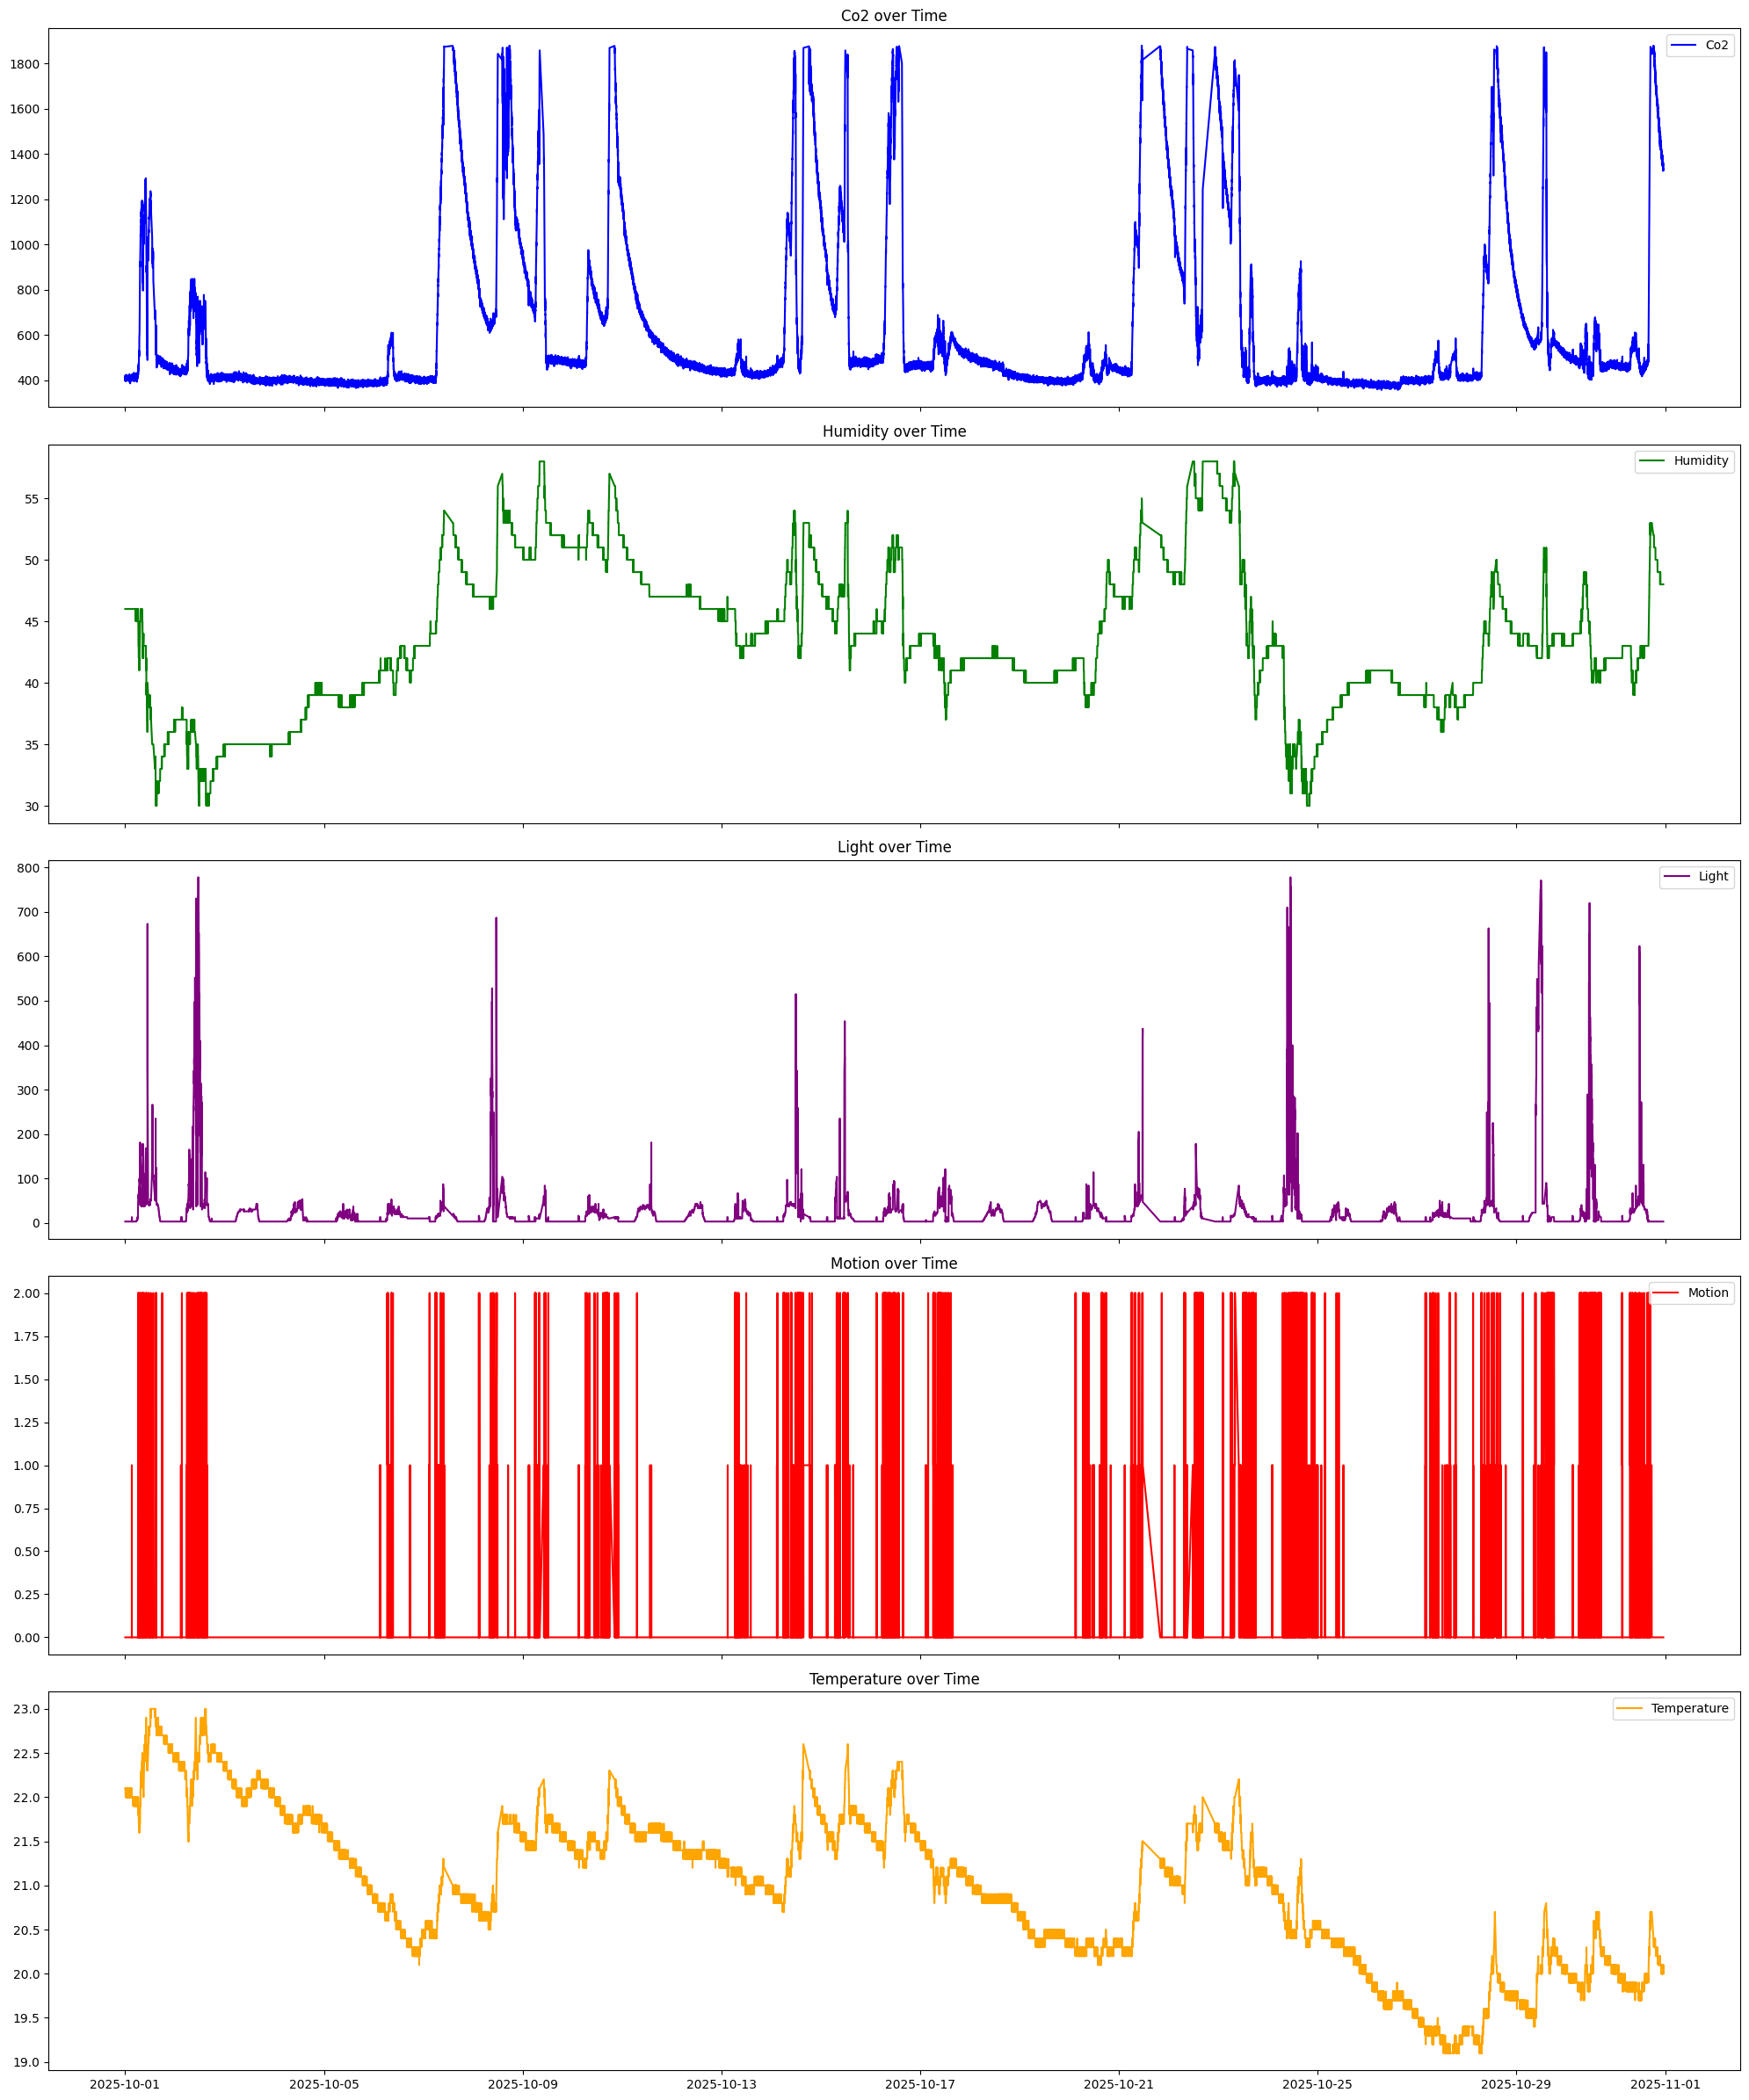

In [29]:
color_map = {'co2': 'blue', 'humidity': 'green', 'light': 'purple', 'motion': 'red', 'temperature': 'orange'}

cols = ['co2', 'humidity', 'light', 'motion', 'temperature']

fig, axes = plt.subplots(len(cols), 1, figsize=(20, 24), sharex=True)

for ax, col in zip(axes, cols):
    ax.plot(df_year.index, df_year[col], label=col.capitalize(), color=color_map[col])
    ax.set_title(f'{col.capitalize()} over Time')
    ax.legend(loc='upper right')

plt.tight_layout()


Text(0.5, 1.0, 'Differenced Temperature over Time')

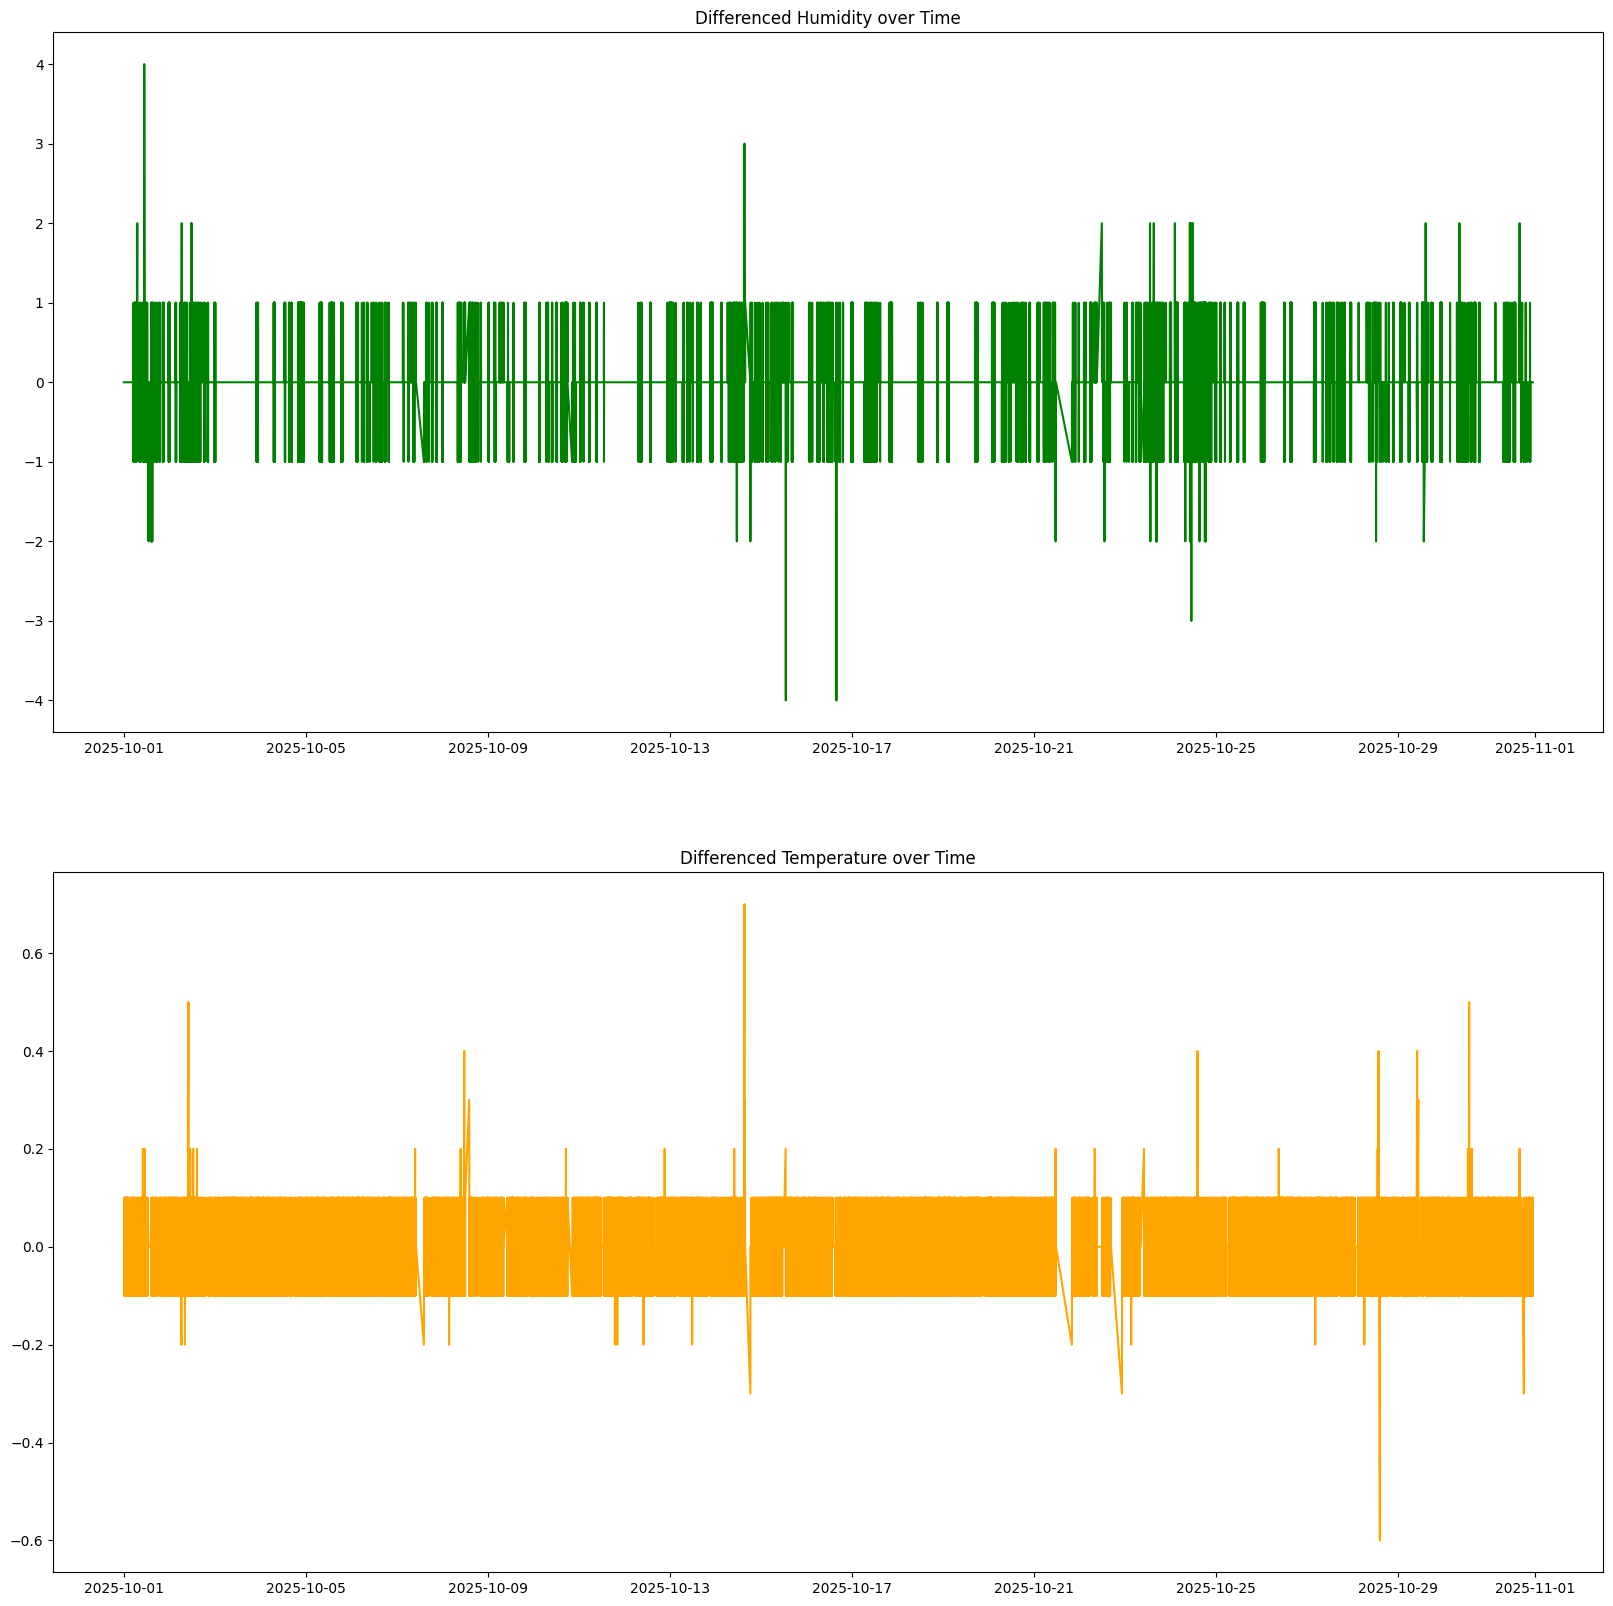

In [20]:
# Create differenced DataFrame
df_diff = df_year.diff().fillna(0)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20))

ax1.plot(df_diff.index, df_diff['humidity'], label='Humidity', color='green')
ax1.set_title('Differenced Humidity over Time')
ax2.plot(df_diff.index, df_diff['temperature'], label='Temperature', color='orange')
ax2.set_title('Differenced Temperature over Time')


Text(0.5, 1.0, 'CO2 over Time')

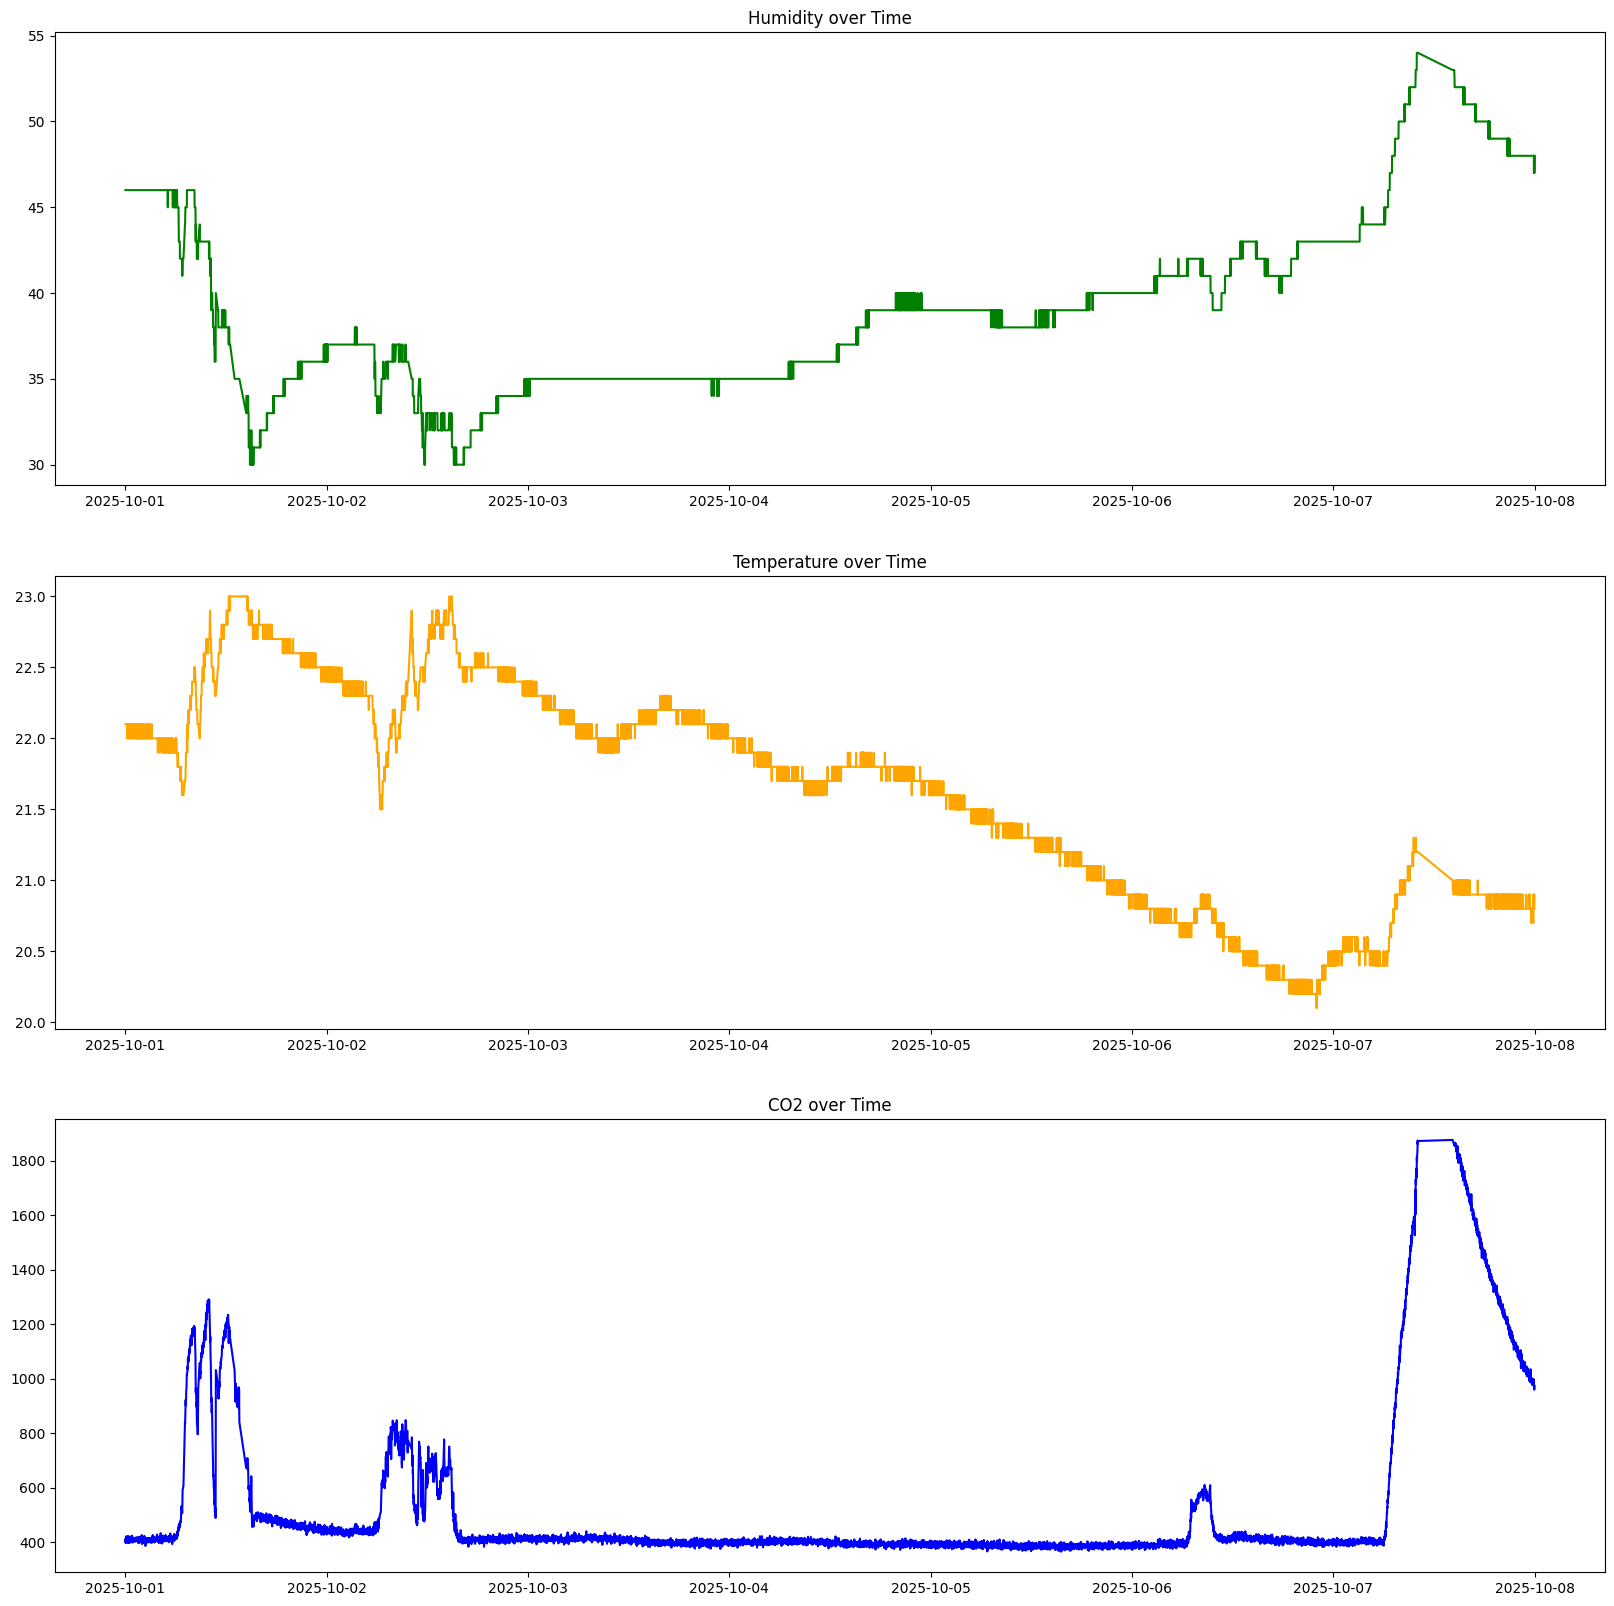

In [24]:
df_week = df_year['2025-10-01':'2025-10-07'].copy() # Monday

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 20))

ax1.plot(df_week.index, df_week['humidity'], label='Humidity', color='green')
ax1.set_title('Humidity over Time')
ax2.plot(df_week.index, df_week['temperature'], label='Temperature', color='orange')
ax2.set_title('Temperature over Time')
ax3.plot(df_week.index, df_week['co2'], label='CO2', color='blue')
ax3.set_title('CO2 over Time')

Text(0.5, 1.0, 'Trend Reduced CO2 over Time')

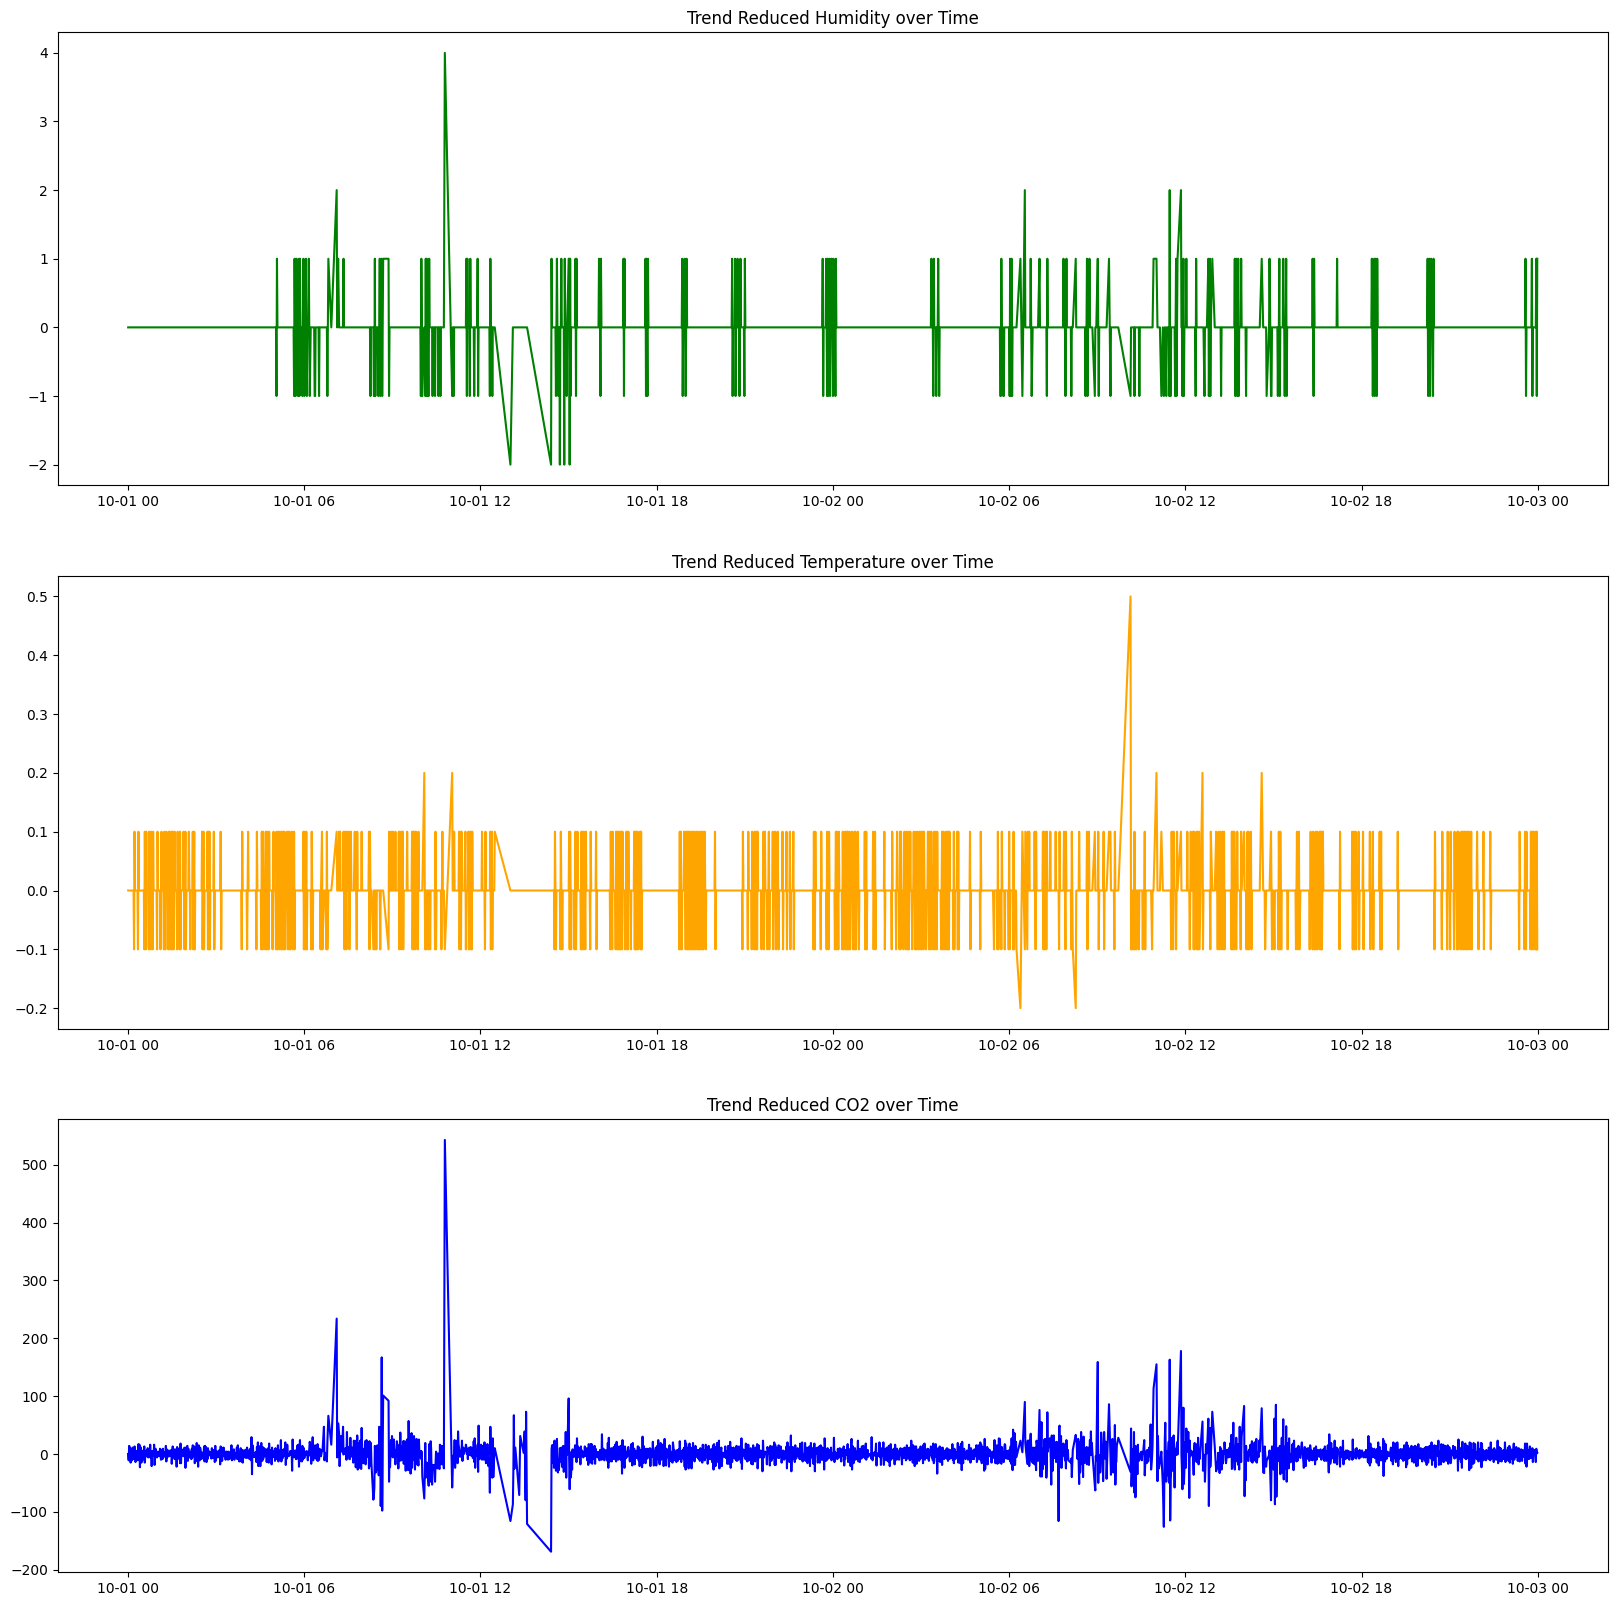

In [25]:
df_diff_week = df_diff['2025-10-01':'2025-10-02'].copy() # Monday

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 20))

ax1.plot(df_diff_week.index, df_diff_week['humidity'], label='Humidity', color='green')
ax1.set_title('Trend Reduced Humidity over Time')
ax2.plot(df_diff_week.index, df_diff_week['temperature'], label='Temperature', color='orange')
ax2.set_title('Trend Reduced Temperature over Time')
ax3.plot(df_diff_week.index, df_diff_week['co2'], label='CO2', color='blue')
ax3.set_title('Trend Reduced CO2 over Time')

Text(0.5, 1.0, 'CO2 and Motion on 2024-04-01:2024-04-07')

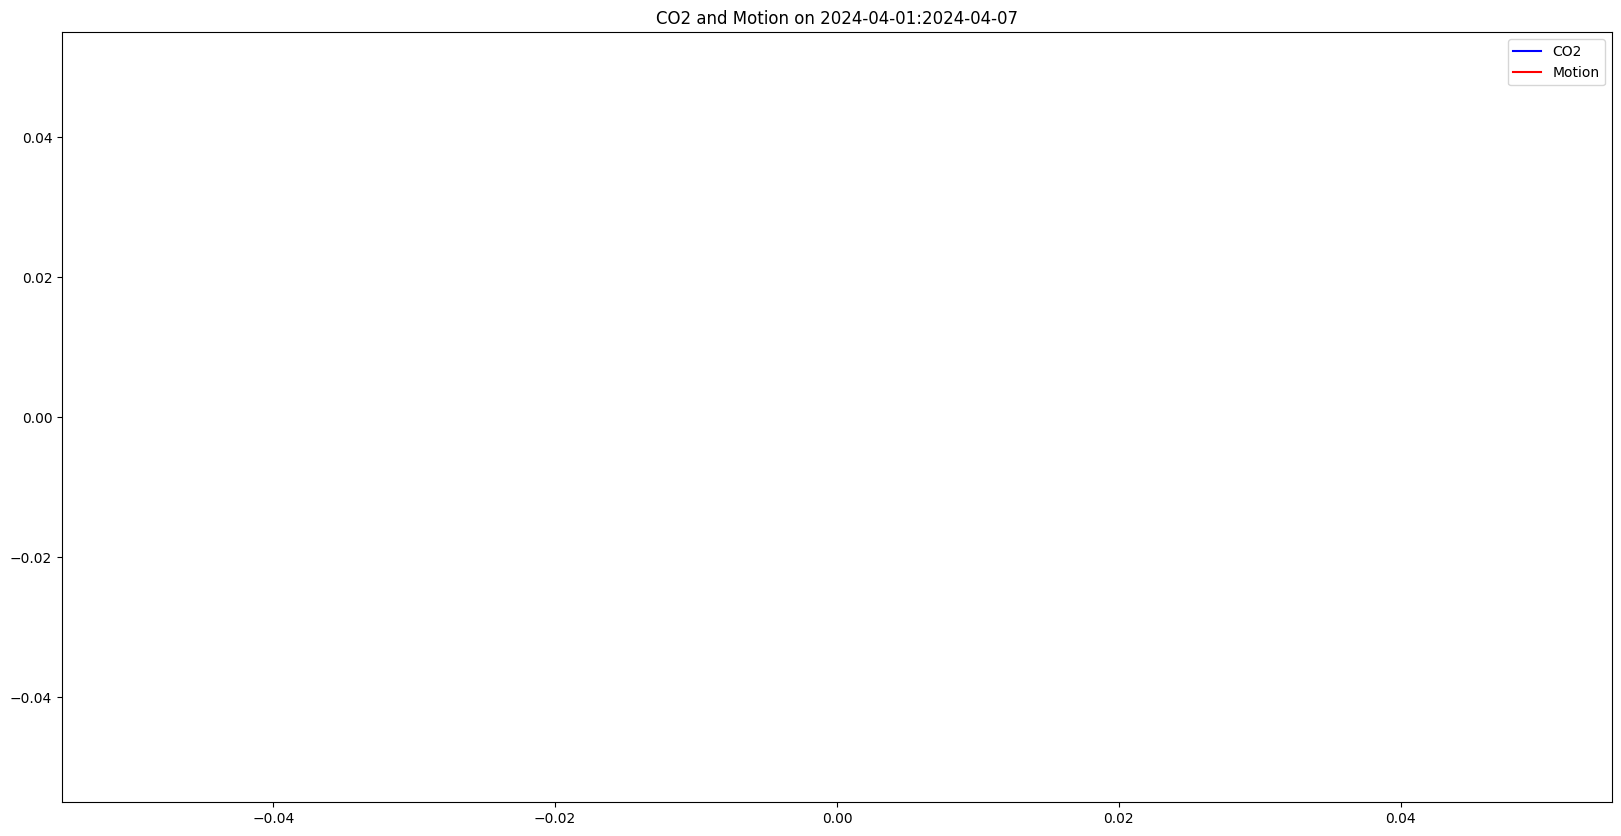

In [23]:
df_diff_week['motion'] = df_diff_week['motion'].astype(bool)

df_motion = df_diff_week['motion'].resample('h').sum()
df_motion = df_motion / df_motion.max() # Normalize motion data

df_diff_week['co2'] = df_diff_week['co2'] / df_diff_week['co2'].max() # Normalize CO2 data

plt.figure(figsize=(20, 10))
plt.plot(df_diff_week.index, df_diff_week['co2'], label='CO2', color='blue')
plt.plot(df_motion.index, df_motion, label='Motion', color='red')
plt.legend()
plt.title('CO2 and Motion on 2024-04-01:2024-04-07')
